In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings("ignore")
 
plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [ ]:
df_covid = pd.read_csv('/content/drive/My Drive/StatewiseTestingDetails.csv')

In [ ]:
print(len(df_covid))
df_covid.head()

5190


,Date,State,TotalSamples,Negative,Positive
0,2020-04-17,Andaman and Nicobar Islands,1403.00000000,1210,12.00000000
1,2020-04-24,Andaman and Nicobar Islands,2679.00000000,NaN,27.00000000
2,2020-04-27,Andaman and Nicobar Islands,2848.00000000,NaN,33.00000000
3,2020-05-01,Andaman and Nicobar Islands,3754.00000000,NaN,33.00000000
4,2020-05-16,Andaman and Nicobar Islands,6677.00000000,NaN,33.00000000


In [ ]:
df = df_covid.loc[df_covid['State'] == 'Karnataka']

#df=df_covid[['Date','TotalSamples']]
df.isnull().sum()

Date             0
State            0
TotalSamples     0
Negative        52
Positive        29
dtype: int64

In [ ]:
df=df[['Date','TotalSamples']]
print(len(df))
df['TotalSamples'] = df['TotalSamples'].astype(int)

160


In [ ]:
df.head()

,Date,TotalSamples
2259,2020-04-03,4587
2260,2020-04-07,6580
2261,2020-04-08,6967
2262,2020-04-09,7613
2263,2020-04-10,7975


In [ ]:
df.tail()

,Date,TotalSamples
2414,2020-09-09,3531441
2415,2020-09-10,3586150
2416,2020-09-11,3650819
2417,2020-09-12,3714402
2418,2020-09-13,3800976


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
# Set the date as index 
df = df.set_index('Date')
df.head()

,TotalSamples
Date,
2020-04-03,4587
2020-04-07,6580
2020-04-08,6967
2020-04-09,7613
2020-04-10,7975


In [ ]:
df.dtypes

TotalSamples    int64
dtype: object

In [ ]:
df.tail()

,TotalSamples
Date,
2020-09-09,3531441
2020-09-10,3586150
2020-09-11,3650819
2020-09-12,3714402
2020-09-13,3800976


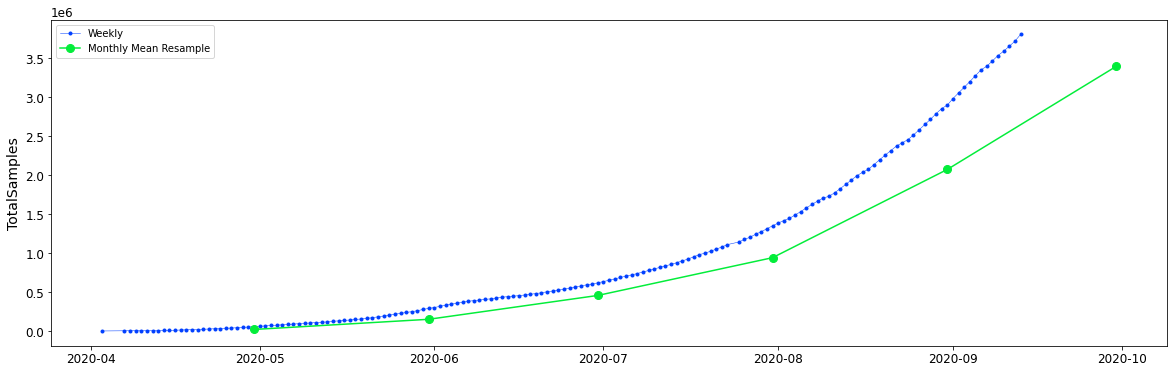

In [ ]:
import warnings
import matplotlib.pyplot as plt
y = df['TotalSamples']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('TotalSamples')
ax.legend();

### Seasonal Decompose

In [ ]:

import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq',freq=150)
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()


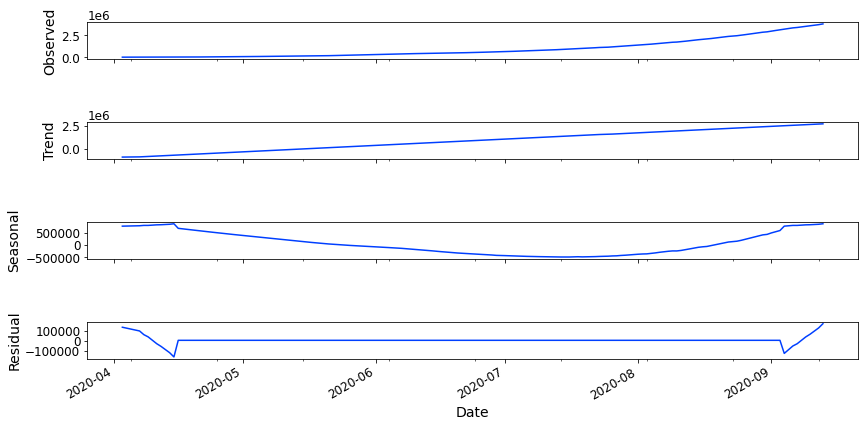

In [ ]:
seasonal_decompose(y)

### Checking for Stationarity

In [ ]:
# plot for Rolling Statistic
def test_stationarity(timeseries, title):
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

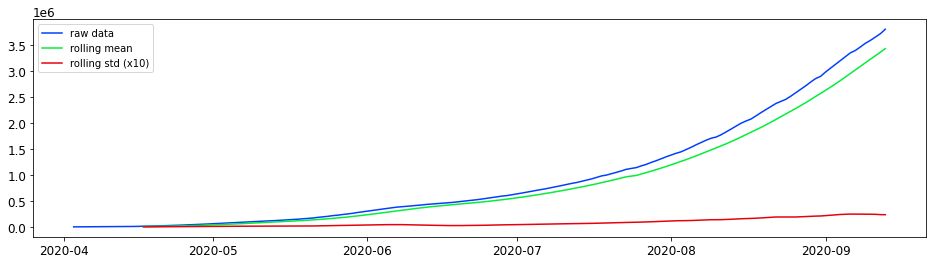

In [ ]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

### Augmented Dickey-Fuller Test

In [ ]:
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print('Results of Dickey-Fuller Test:')
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [ ]:
ADF_test(y,'raw data')

Results of Dickey-Fuller Test:
 > Is the raw data stationary ?
Test statistic = 0.418
P-value = 0.982
Critical values :
	1%: -3.476273058920005 - The data is not stationary with 99% confidence
	5%: -2.881687616548444 - The data is not stationary with 95% confidence
	10%: -2.5775132580261593 - The data is not stationary with 90% confidence


### Detrending

Results of Dickey-Fuller Test:
 > Is the de-trended data stationary ?
Test statistic = -3.688
P-value = 0.004
Critical values :
	1%: -3.479007355368944 - The data is  stationary with 99% confidence
	5%: -2.8828782366015093 - The data is  stationary with 95% confidence
	10%: -2.5781488587564603 - The data is  stationary with 90% confidence


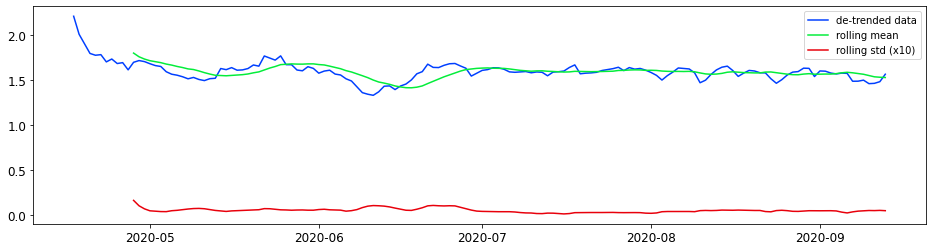

In [ ]:
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

### Differencing

Results of Dickey-Fuller Test:
 > Is the 12 lag differenced data stationary ?
Test statistic = 0.557
P-value = 0.987
Critical values :
	1%: -3.480118600110386 - The data is not stationary with 99% confidence
	5%: -2.8833618426136196 - The data is not stationary with 95% confidence
	10%: -2.578407034974382 - The data is not stationary with 90% confidence


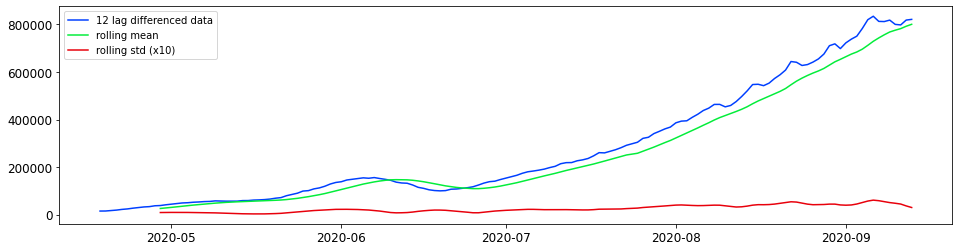

In [ ]:
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

### Detrending and Differencing to make the data stationary

Results of Dickey-Fuller Test:
 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -4.423
P-value = 0.000
Critical values :
	1%: -3.4846672514209773 - The data is  stationary with 99% confidence
	5%: -2.8853397507076006 - The data is  stationary with 95% confidence
	10%: -2.5794629869786503 - The data is  stationary with 90% confidence


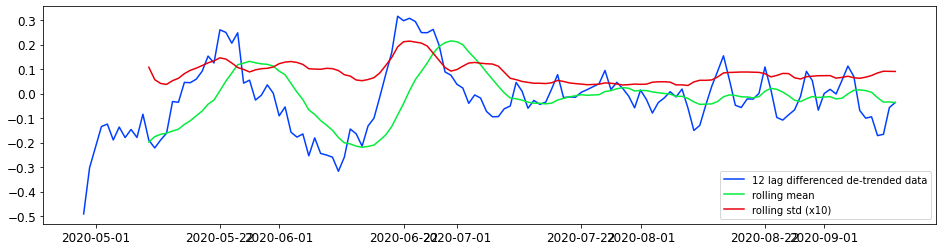

In [ ]:
y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

In [ ]:
y_to_train = y[:'2020-08-13'] # dataset to train
y_to_val = y['2020-08-14':] # last 1 month for testing  
predict_date = len(y) - len(y[:'2020-08-14']) 

### SARIMA for forecasting

In [ ]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))


In [ ]:
sarima_grid_search(y,52)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(1, 1, 0, 52) - AIC:1161.741948079849


In [ ]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0122      0.003    294.149      0.000       1.005       1.019
ma.L1         -0.8217      0.057    -14.383      0.000      -0.934      -0.710
ar.S.L52      -0.7243      0.341     -2.121      0.034      -1.394      -0.055
sigma2       6.58e+07   4.28e-09   1.54e+16      0.000    6.58e+07    6.58e+07


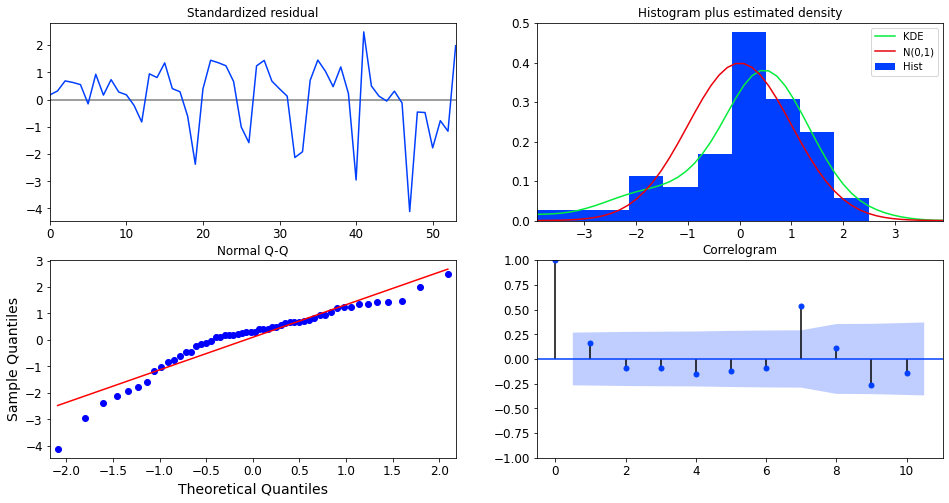

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 11750.34


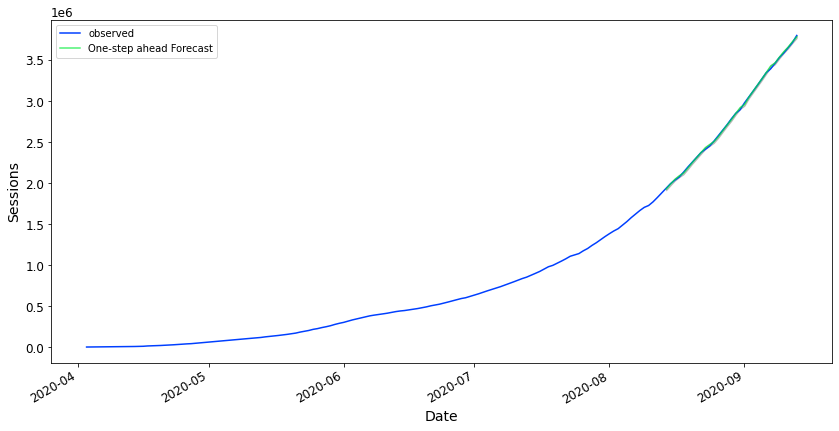

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = True 69532.36


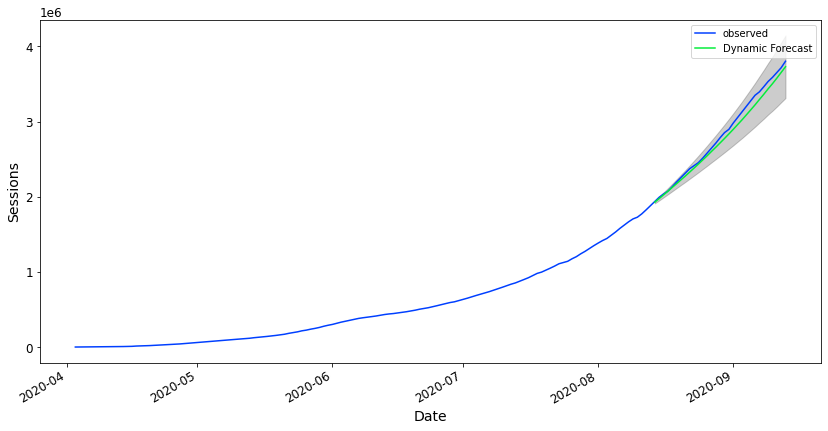

In [ ]:
model = sarima_eva(y,(1, 1, 1),(1, 1, 0, 52),52,'2020-08-14',y_to_val)